In [47]:
#%pip freeze > requirements.txt


In [48]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


## Librerias y cargar dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
#from google.colab import files
import zipfile

2023-12-05 11:07:17.790109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 11:07:18.480103: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-05 11:07:18.480153: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-12-05 11:07:18.480158: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [50]:
#uploaded = files.upload()

In [51]:
#with zipfile.ZipFile("DroughtDatasetMask.zip", 'r') as data:
 #   data.extractall("DroughtDatasetMask/dataset")

## Funciones

In [8]:
def create_shifted_frames_2(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, data.shape[1]-1, :, :]
    return x, y

#Toma todos los colores existentes en la imagen
def get_colors(image):
  aux = []
  band = True
  for i in image:
    for j in i:

      for k in aux:
        if j.tolist() == k:
          band = False
          break
      if band:
        aux.append(j.tolist())
      band = True
  return np.array(aux)

def balance_img_categories(img, palette, balancer):
  #palette = np.sort(palette)
  rows = len(img)
  cols = len(img[0])
  for i in range(rows):
    for j in range(cols):
      pos = np.where(palette == img[i,j])[0][0]
      img[i,j] = balancer[pos]
  return img


#Función para dada una paleta solo tomar los colores de esa paleta en la imagen
def quantizetopalette(silf, palette, dither=False, mode="P"):
  """Convert an RGB or L mode image to use a given P image's palette."""
  silf.load()
  palette.load()
  im = silf.im.convert(mode, 0, palette.im)
  # the 0 above means turn OFF dithering making solid colors
  return silf._new(im)

#Realiza las operaciones necesarias para obtener una imagen RGB por una paleta de colores
def rgb_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('P', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img).convert("RGB")
  newImage = quantizetopalette(oldImage,palImage)
  res_image = np.asarray(newImage.convert("RGB"))
  return res_image

def gray_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('L', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img, 'L')
  newImage = quantizetopalette(oldImage,palImage, mode="L")
  res_image = np.asarray(newImage)
  return res_image

def recolor_greys_image(data, palette):
    rows, cols = len(data), len(data[0])
    aux = np.zeros((rows, cols), dtype=np.uint64)
    for i in range(rows):
        for j in range(cols):
            aux[i,j] = min(palette, key= lambda x:abs(x-data[i,j]))
    return aux


def agroup_window(data, window):
    new_data = [data[i:window+i] for i in range(len(data)-window+1)]
    return np.array(new_data)


def add_last(data, new_vals):
    print(f"data: {data.shape} y new_val: {new_vals.shape}")
    x_test_new = data[:,1:]
    print(f"x_test_new: {x_test_new.shape}")

    l = []
    for i in range(len(x_test_new)):
        l.append(np.append(x_test_new[i], new_vals[i]))
    x_test_new = np.array(l).reshape(data.shape[:])
    print("CX", x_test_new.shape)
    return x_test_new

def add_lastNew(data, new_val):
    print(f"data: {data.shape} y new_val: {new_val.shape}")
    x_test_new = data[:,1:,...]  # Omite el primer paso de tiempo
    print(f"x_test_new: {x_test_new.shape}")

    # Asumiendo que new_val es una única predicción que se debe añadir a cada paso de tiempo en x_test_new
    new_val = new_val.squeeze(axis=0)  # Elimina la dimensión del batch, si es necesario

    print(new_val.shape)
    # Añadir new_val a cada elemento en x_test_new
    x_test_new = np.concatenate((x_test_new, np.expand_dims(new_val, axis=1)), axis=1)

    print("CX", x_test_new.shape)
    return x_test_new


    #Crea cubos con su propia información de tamaño h
def get_cubes(data, h):
    new_data = []
    for i in range(0, len(data)-h):
        new_data.append(data[i:i+h])
    new_data = np.array(new_data)
    print(new_data.shape)
    return new_data

## Codigo

Variables iniciales para correr el codigo

In [46]:
rowsTraining = 61
colsTraining = 180
channels = 1
window = 5
categories = [0, 35, 70, 119, 177, 220, 255] 
horizon = 4

parte0_0 = "Part0_0"
parte0_1 = "Part0_1"
parte1_0 = "Part1_0"
parte1_1 = "Part1_1"

imagenInicial = 300

De la carpeta con las imagenes pasarlo a un arreglo npy

In [54]:
## Set the path to the folder containing the images
#path = "DroughtDatasetMask/dataset/DroughtDatasetMask"
#
## Get a list of all the image file names in the folder
#image_files = [f for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]
#
## Suponiendo que todas las imágenes tienen el tamaño deseado de 122x360
#num_images = len(image_files)  # Asegúrate de que este número corresponde al número de imágenes que deseas cargar
#
## Verifica que tengas la cantidad correcta de archivos de imagen
#if len(image_files) != num_images:
#    raise ValueError(f"Expected {num_images} images, but found {len(image_files)}")
#
## Create an empty numpy array to hold the images
#images = np.zeros((num_images, rows, cols), dtype=np.uint8)  # Asegúrate de que el tipo de datos sea correcto
#
## Loop through the image files and add each image to the numpy array
#for i, file in enumerate(sorted(image_files)[:num_images]):  # Asegúrate de que no excedas el número de imágenes deseado
#    # Load the image using OpenCV
#    img = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)  # Directamente en escala de grises
#    if img.shape != (rows, cols):
#        raise ValueError(f"The image {file} has a shape of {img.shape}, but expected {(rows, cols)}")
#    # Add the image to the numpy array
#    images[i] = img
#
## Save the numpy array to a file
#np.save("DroughtDatasetMask/DroughtDatasetMask.npy", images)
#print("Images shape: {}".format(images.shape))

cargar dataset en formato npy

In [44]:
x00 = np.load("DroughtDatasetMask/NPY61_180Part0_0/DroughtDatasetMask_Part0_0.npy")
x01 = np.load("DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_1/DroughtDatasetMaskBordesNuevos0_1v2.npy")
x10 = np.load("DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_0/DroughtDatasetMaskBordesNuevos1_0v2.npy")
x11 = np.load("DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_1/DroughtDatasetMaskBordesNuevos1_1v2.npy")
print ("00",x00.shape)
print ("01",x01.shape)
print ("10",x10.shape)
print ("11",x11.shape)

00 (1240, 61, 180)
01 (1240, 61, 190)
10 (1240, 71, 180)
11 (1240, 71, 190)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Number of devices: 2
rows 61
cols 190
Parte Part0_1
x (1240, 61, 190)
x uint8
x 0
x 255
Colores [  0 255 113 219 226 224 221 213 223 222 214 220 208 188 215 169 194 181
 192 190 218 216 209 198 211 225 203 217 176 177 205 187 212 210 201  69
 162 150 182 172 200 175 206 204 178]
(1240, 61, 190)
Colores [  0 255 113 219 226 224 221 213 223 222 214 220 208 188 215 169 194 181
 192 190 218 216 209 198 211 225 203 217 176 177 205 187 212 210 201  69
 162 150 182 172 200 175 206 204 178]
(1240, 61, 190)
[0.         1.         0.46666667 0.86274511 0.69411767 0.27450982]
(1240, 61, 190)
(1236, 5, 61, 190)
Forma de datos de entrenamiento: (692, 5, 61, 190, 1)
Forma de datos de validación: (173, 5, 61, 190, 1)
Forma de datos de pruebas: (371, 5, 61, 190, 1)
Training dataset shapes: (692, 4, 61, 190, 1), (692, 61, 190, 1)
Validation dataset shapes: (173, 4, 61, 190, 1), (173, 61, 190, 1)
Test dataset shapes: (371, 4, 61, 190, 1), (371, 61, 190, 1)
Model: "model_2"
______________________________

2023-12-06 09:22:18.034770: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/replica_1/model_2/conv_lstm2d_8/while/replica_1/model_2/conv_lstm2d_8/while_grad/body/_1679/input/_3362' -> 'gradient_tape/replica_1/model_2/conv_lstm2d_8/while/replica_1/model_2/conv_lstm2d_8/while_grad/body/_1679/gradient_tape/replica_1/model_2/conv_lstm2d_8/while/gradients/AddN', 'Func/gradient_tape/model_2/conv_lstm2d_8/while/model_2/conv_lstm2d_8/while_grad/body/_555/input/_2654' -> 'gradient_tape/model_2/conv_lstm2d_8/while/model_2/conv_lstm2d_8/while_grad/body/_555/gradient_tape/model_2/conv_lstm2d_8/while/gradients/AddN', 'Func/gradient_tape/replica_1/model_2/conv_lstm2d_7/while/replica_1/model_2/conv_lstm2d_7/while_grad/body/_1874/input/_3481' -> 'gradient_tape/replica_1/model_2/conv_lstm2d_7/while/replica_1/model_2/conv_lstm2d_7/while_grad/body/_1874/gradient

Training log was saved to DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_1/InfoConvLSTM2D_Mask61_190.txt
lengeth x_test: 371
300
(4, 61, 190, 1)
186/186 [==============================] - 2s 10ms/step - loss: 0.0929
El error del modelo es: 0.09291183948516846
186/186 [==============================] - 3s 8ms/step
(371, 61, 190, 1)
data: (371, 4, 61, 190, 1) y new_val: (371, 61, 190, 1)
x_test_new: (371, 3, 61, 190, 1)
CX (371, 4, 61, 190, 1)
186/186 [==============================] - 2s 8ms/step
data: (371, 4, 61, 190, 1) y new_val: (371, 61, 190, 1)
x_test_new: (371, 3, 61, 190, 1)
CX (371, 4, 61, 190, 1)
186/186 [==============================] - 2s 9ms/step
data: (371, 4, 61, 190, 1) y new_val: (371, 61, 190, 1)
x_test_new: (371, 3, 61, 190, 1)
CX (371, 4, 61, 190, 1)
186/186 [==============================] - 2s 8ms/step
data: (371, 4, 61, 190, 1) y new_val: (371, 61, 190, 1)
x_test_new: (371, 3, 61, 190, 1)
CX (371, 4, 61, 190, 1)
PREDSS (371, 4, 61, 190, 1)
Res_forecast (371

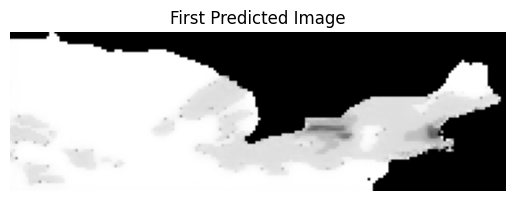

rows 71
cols 180
Parte Part1_0
x (1240, 71, 180)
x uint8
x 0
x 255
Colores [  0 133 172 176 156  69 173  76  99 162 175 165 174 206 215 222 226 213
 210  89 177 214 187 110  78 197 212 113 143 126  70 119 211 224 205  90
 190  81 161 180 217 130 159 170 104 193 223 150 209 198 204 200 208 101
 148  72 166  82 184 220 178 255  67  52  50  62 225 219 168 182  59  34
 189 127 154  60  66 194  48  98 181  71  83  36  64 138 167 129 117  40
  68  38 191 203 195 179  41 202  57  77 216 218 139  94 169 221 201 199
 192 111]
(1240, 71, 180)
Colores [  0 133 172 176 156  69 173  76  99 162 175 165 174 206 215 222 226 213
 210  89 177 214 187 110  78 197 212 113 143 126  70 119 211 224 205  90
 190  81 161 180 217 130 159 170 104 193 223 150 209 198 204 200 208 101
 148  72 166  82 184 220 178 255  67  52  50  62 225 219 168 182  59  34
 189 127 154  60  66 194  48  98 181  71  83  36  64 138 167 129 117  40
  68  38 191 203 195 179  41 202  57  77 216 218 139  94 169 221 201 199
 192 111]
(1240

2023-12-06 09:27:47.676367: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/replica_1/model_3/conv_lstm2d_11/while/replica_1/model_3/conv_lstm2d_11/while_grad/body/_1679/input/_3362' -> 'gradient_tape/replica_1/model_3/conv_lstm2d_11/while/replica_1/model_3/conv_lstm2d_11/while_grad/body/_1679/gradient_tape/replica_1/model_3/conv_lstm2d_11/while/gradients/AddN', 'Func/gradient_tape/model_3/conv_lstm2d_11/while/model_3/conv_lstm2d_11/while_grad/body/_555/input/_2654' -> 'gradient_tape/model_3/conv_lstm2d_11/while/model_3/conv_lstm2d_11/while_grad/body/_555/gradient_tape/model_3/conv_lstm2d_11/while/gradients/AddN', 'Func/gradient_tape/replica_1/model_3/conv_lstm2d_10/while/replica_1/model_3/conv_lstm2d_10/while_grad/body/_1874/input/_3481' -> 'gradient_tape/replica_1/model_3/conv_lstm2d_10/while/replica_1/model_3/conv_lstm2d_10/while_grad/body/

Training log was saved to DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_0/InfoConvLSTM2D_Mask71_180.txt
lengeth x_test: 371
300
(4, 71, 180, 1)
186/186 [==============================] - 2s 10ms/step - loss: 0.1938
El error del modelo es: 0.19384412467479706
186/186 [==============================] - 4s 10ms/step
(371, 71, 180, 1)
data: (371, 4, 71, 180, 1) y new_val: (371, 71, 180, 1)
x_test_new: (371, 3, 71, 180, 1)
CX (371, 4, 71, 180, 1)
186/186 [==============================] - 2s 9ms/step
data: (371, 4, 71, 180, 1) y new_val: (371, 71, 180, 1)
x_test_new: (371, 3, 71, 180, 1)
CX (371, 4, 71, 180, 1)
186/186 [==============================] - 2s 9ms/step
data: (371, 4, 71, 180, 1) y new_val: (371, 71, 180, 1)
x_test_new: (371, 3, 71, 180, 1)
CX (371, 4, 71, 180, 1)
186/186 [==============================] - 2s 9ms/step
data: (371, 4, 71, 180, 1) y new_val: (371, 71, 180, 1)
x_test_new: (371, 3, 71, 180, 1)
CX (371, 4, 71, 180, 1)
PREDSS (371, 4, 71, 180, 1)
Res_forecast (37

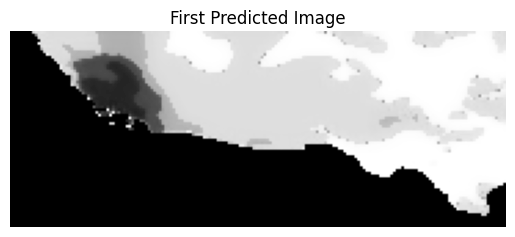

rows 71
cols 190
Parte Part1_1
x (1240, 71, 190)
x uint8
x 0
x 255
Colores [215 213 212 255   0 217 224 210 204 200 208 214 223 176 226 113 182 225
 216 220 203 188 175 219 209 181 222 198 221 211 218 169 206 177 197 190
 184 194 201 189 180 178 199 117  99 101 172 156 138 126 119 133 165 173
  69 174 110  57  68  81 187  34  89  36 202  40  67 161 205 159 193 127
 170  82 162 167  78 139 168  83  70 111 129 191 179  77 130  94 150  72
  71  48 104 154]
(1240, 71, 190)
Colores [215 213 212 255   0 217 224 210 204 200 208 214 223 176 226 113 182 225
 216 220 203 188 175 219 209 181 222 198 221 211 218 169 206 177 197 190
 184 194 201 189 180 178 199 117  99 101 172 156 138 126 119 133 165 173
  69 174 110  57  68  81 187  34  89  36 202  40  67 161 205 159 193 127
 170  82 162 167  78 139 168  83  70 111 129 191 179  77 130  94 150  72
  71  48 104 154]
(1240, 71, 190)
[0.86274511 1.         0.         0.69411767 0.46666667 0.27450982
 0.13725491]
(1240, 71, 190)
(1236, 5, 71, 190)
Form

2023-12-06 09:35:33.546525: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/replica_1/model_4/conv_lstm2d_14/while/replica_1/model_4/conv_lstm2d_14/while_grad/body/_1679/input/_3362' -> 'gradient_tape/replica_1/model_4/conv_lstm2d_14/while/replica_1/model_4/conv_lstm2d_14/while_grad/body/_1679/gradient_tape/replica_1/model_4/conv_lstm2d_14/while/gradients/AddN', 'Func/gradient_tape/model_4/conv_lstm2d_14/while/model_4/conv_lstm2d_14/while_grad/body/_555/input/_2654' -> 'gradient_tape/model_4/conv_lstm2d_14/while/model_4/conv_lstm2d_14/while_grad/body/_555/gradient_tape/model_4/conv_lstm2d_14/while/gradients/AddN', 'Func/gradient_tape/replica_1/model_4/conv_lstm2d_13/while/replica_1/model_4/conv_lstm2d_13/while_grad/body/_1874/input/_3481' -> 'gradient_tape/replica_1/model_4/conv_lstm2d_13/while/replica_1/model_4/conv_lstm2d_13/while_grad/body/

Training log was saved to DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_1/InfoConvLSTM2D_Mask71_190.txt
lengeth x_test: 371
300
(4, 71, 190, 1)
186/186 [==============================] - 2s 10ms/step - loss: 0.0852
El error del modelo es: 0.08517024666070938
186/186 [==============================] - 3s 9ms/step
(371, 71, 190, 1)
data: (371, 4, 71, 190, 1) y new_val: (371, 71, 190, 1)
x_test_new: (371, 3, 71, 190, 1)
CX (371, 4, 71, 190, 1)
186/186 [==============================] - 2s 9ms/step
data: (371, 4, 71, 190, 1) y new_val: (371, 71, 190, 1)
x_test_new: (371, 3, 71, 190, 1)
CX (371, 4, 71, 190, 1)
186/186 [==============================] - 2s 9ms/step
data: (371, 4, 71, 190, 1) y new_val: (371, 71, 190, 1)
x_test_new: (371, 3, 71, 190, 1)
CX (371, 4, 71, 190, 1)
186/186 [==============================] - 2s 9ms/step
data: (371, 4, 71, 190, 1) y new_val: (371, 71, 190, 1)
x_test_new: (371, 3, 71, 190, 1)
CX (371, 4, 71, 190, 1)
PREDSS (371, 4, 71, 190, 1)
Res_forecast (371

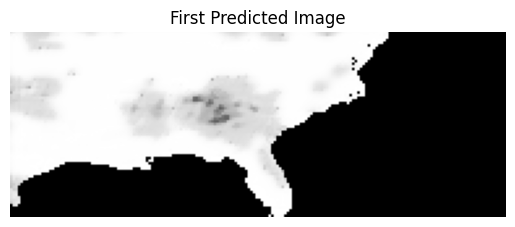

In [50]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():

    for x in [x01, x10, x11]:
        if x is x00:
            parte = parte0_0
            rows = x00.shape[1]
            cols = x00.shape[2]
            print("rows",rows)
            print("cols",cols)
        elif x is x01:
            parte = parte0_1
            rows = x01.shape[1]
            cols = x01.shape[2]
            print("rows",rows)
            print("cols",cols)
        elif x is x10:
            parte = parte1_0
            rows = x10.shape[1]
            cols = x10.shape[2]
            print("rows",rows)
            print("cols",cols)
        elif x is x11:
            parte = parte1_1
            rows = x11.shape[1]
            cols = x11.shape[2]
            print("rows",rows)
            print("cols",cols)
        
        print("Parte", parte)

        print("x", x.shape)
        print("x", x.dtype)
        print("x", x.min())
        print("x", x.max())
        
        x = np.array([gray_quantized(i, np.array(categories)) for i in x])
        colors_greys = get_colors(x[1168])
        print(f"Colores {colors_greys}")
        print(x.shape)

        #inicio
        x = np.array([gray_quantized(i, np.array(categories)) for i in x])
        colors_greys = get_colors(x[1168])
        print(f"Colores {colors_greys}")
        print(x.shape)

        x_greys = np.array([recolor_greys_image(img, categories) for img in x])
        x = x_greys.astype('float32') / 255
        print(get_colors(x[1168]))
        print(x.shape)

        x_2 = agroup_window(x, window)
        print(x_2.shape)
        x_train = x_2[:int(len(x_2)*.7)]
        x_test = x_2[int(len(x_2)*.7):]
        x_validation = x_train[int(len(x_train)*.8):]
        x_train = x_train[:int(len(x_train)*.8)]

        x_train = x_train.reshape(len(x_train), window, rows, cols, channels)
        x_validation = x_validation.reshape(len(x_validation), window, rows, cols, channels)
        x_test = x_test.reshape(len(x_test), window, rows, cols, channels)

        print("Forma de datos de entrenamiento: {}".format(x_train.shape))
        print("Forma de datos de validación: {}".format(x_validation.shape))
        print("Forma de datos de pruebas: {}".format(x_test.shape))

        x_train, y_train = create_shifted_frames_2(x_train)
        x_validation, y_validation = create_shifted_frames_2(x_validation)
        x_test, y_test = create_shifted_frames_2(x_test)

        print("Training dataset shapes: {}, {}".format(x_train.shape, y_train.shape))
        print("Validation dataset shapes: {}, {}".format(x_validation.shape, y_validation.shape))
        print("Test dataset shapes: {}, {}".format(x_test.shape, y_test.shape))

        #DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_1
        np.save("DroughtDatasetMask/dataset/BordesNuevos/61_180"+parte+"/x_test_mask.npy", x_test)
        np.save("DroughtDatasetMask/dataset/BordesNuevos/61_180"+parte+"/y_test_mask.npy", y_test)
        np.save("DroughtDatasetMask/dataset/BordesNuevos/61_180"+parte+"/x_train_mask.npy", x_train)
        np.save("DroughtDatasetMask/dataset/BordesNuevos/61_180"+parte+"/y_train_mask.npy", y_train)
        np.save("DroughtDatasetMask/dataset/BordesNuevos/61_180"+parte+"/x_validation_mask.npy", x_validation)
        np.save("DroughtDatasetMask/dataset/BordesNuevos/61_180"+parte+"/y_validation_mask.npy", y_validation)

        import sys

        # Define the path where you want to save the log file
        log_file_path = "DroughtDatasetMask/dataset/BordesNuevos/61_180"+parte+"/InfoConvLSTM2D_Mask"+str(rows)+"_"+str(cols)+".txt"

        # Save the original stdout so we can restore it later
        original_stdout = sys.stdout

        #Construction of Convolutional LSTM network
        inp = keras.layers.Input(shape=(None, *x_train.shape[2:]))
        #It will be constructed a 3 ConvLSTM2D layers with batch normalization,
        #Followed by a Conv3D layer for the spatiotemporal outputs.
        m = keras.layers.ConvLSTM2D(16, (5,5), padding= "same", return_sequences= True, activation= "relu")(inp)
        m = keras.layers.BatchNormalization()(m)
        m = keras.layers.ConvLSTM2D(16, (5,5), padding= "same", return_sequences= True, activation= "relu")(m)
        m = keras.layers.BatchNormalization()(m)
        m = keras.layers.ConvLSTM2D(16, (3,3), padding= "same", activation= "relu")(m)
        m = keras.layers.Conv2D(channels, (3,3), activation= "sigmoid", padding= "same")(m)
        model = keras.models.Model(inp, m)
        model.compile(loss= "binary_crossentropy", optimizer= "Adam")
        print(model.summary())
        #Callbacks
        early_stopping = keras.callbacks.EarlyStopping(monitor= "val_loss", patience= 6, restore_best_weights= True)
        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor= "val_loss", patience= 6)
        model_checkpoint = keras.callbacks.ModelCheckpoint(
            filepath= "DroughtDatasetMask/dataset/BordesNuevos/61_180"+parte+"/ConvLSTM2D_Mask"+str(rows)+"_"+str(cols)+".h5",
            monitor= "val_loss",
            save_best_only= True,
            mode= "min"
        )
        # Model training with logs redirected to a file
        with open(log_file_path, 'w') as log_file:
            sys.stdout = log_file  # Redirect stdout to the log file
            model.fit(
                x_train, y_train,
                batch_size=2,
                epochs=30,
                validation_data=(x_validation, y_validation),
                callbacks=[early_stopping, reduce_lr]
            )
            sys.stdout = original_stdout  # Restore stdout back to normal

        print(f"Training log was saved to {log_file_path}")

        #Guardar el modelo
        
        model.save("DroughtDatasetMask/dataset/BordesNuevos/61_180"+parte+"/ConvLSTM2D_Mask"+str(rows)+"_"+str(cols)+".h5")
    

        print (f"lengeth x_test: {len(x_test)}")
#        imagenInicial = np.random.choice(range(len(x_test)), size= 1)[0]
        print(imagenInicial)

        example = x_test[imagenInicial]

        print(example.shape)

        err = model.evaluate(x_test, y_test, batch_size= 2)
        print("El error del modelo es: {}".format(err))
        preds = model.predict(x_test, batch_size= 2)
        print(preds.shape)
        x_test_new = add_last(x_test, preds[:])
        preds2 = model.predict(x_test_new, batch_size= 2)
        #print(preds2.shape)
        x_test_new = add_last(x_test_new, preds2[:])
        preds3 = model.predict(x_test_new, batch_size= 2)
        x_test_new = add_last(x_test_new, preds3[:])
        preds4 = model.predict(x_test_new, batch_size= 2)
        res_forecast = add_last(x_test_new, preds4[:])
        print("PREDSS",res_forecast.shape)

        np.save("DroughtDatasetMask/dataset/BordesNuevos/61_180"+parte+"/PredictionsConvolutionLSTM_forecast_"+str(rows)+"_"+str(cols)+"_"+parte+"_w"+str(window)+".npy", res_forecast)  #Guardar el vector de predicciones

        print("Res_forecast" , res_forecast.shape)

        print("x_test" , x_test.shape)
        print("x_test_new" , x_test_new.shape)
        print("y_test" , y_test.shape)

        # Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()
        plt.imshow(preds[0].squeeze(), cmap='gray')
        plt.title("First Predicted Image")
        plt.axis('off')
        plt.show()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
61
180
(371, 4, 61, 180, 1)
(371, 4, 61, 180, 1)
(371, 61, 180, 1)
(367, 4, 61, 180, 1)
COLORSS [[0.        ]
 [0.69411767]
 [0.86274511]
 [1.        ]
 [0.46666667]
 [0.27450982]
 [0.13725491]]
COLORS (7, 1)
COLORSS [[2.53105536e-05]
 [6.92415006e-06]
 [1.27266567e-05]
 ...
 [6.76609457e-01]
 [8.09626460e-01]
 [7.98062205e-01]]
XX
(367, 4, 61, 180, 1)
(367, 4, 61, 180, 1)
(367, 4, 61, 180, 1)
[1.8512529e-06]
[0.99658006]
new_data (367, 4, 61, 180, 1)
(9562, 1)
[0]
[254]
HoY (367, 4, 61, 180)
SHAPEE (367, 4, 61, 180)
DCOLORS [  0 177 220 255 119  70  35]
YCOLORS [[  0.]
 [177.]
 [220.]
 [255.]
 [119.]
 [ 70.]
 [ 35.]]
NCOLORS [[  0.]
 [177.]
 [220.]
 [255.]
 [119.]
 [ 70.]
 [ 35.]]
DCOLORS [[  0]
 [177]
 [220]
 [255]
 [119]
 [ 70]
 [ 35]]
XS
new data shape (367, 4, 61, 180, 1)
y_test.shape (367, 4, 61, 180, 1)
new data

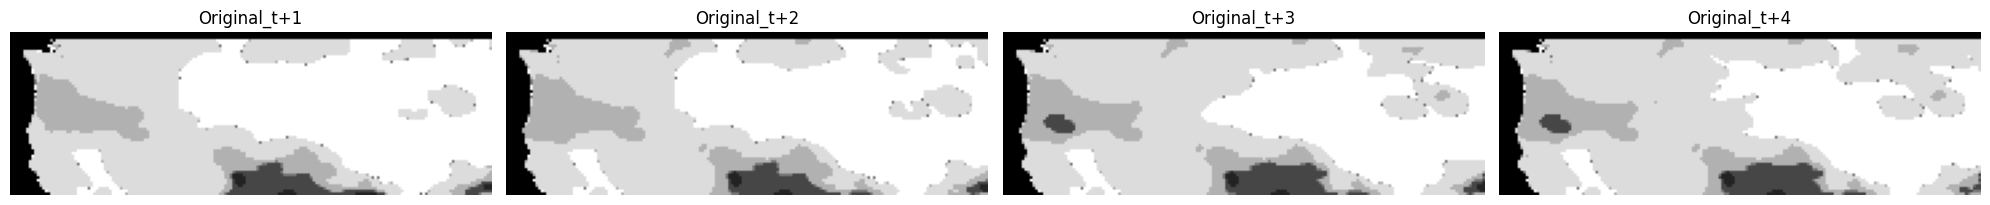

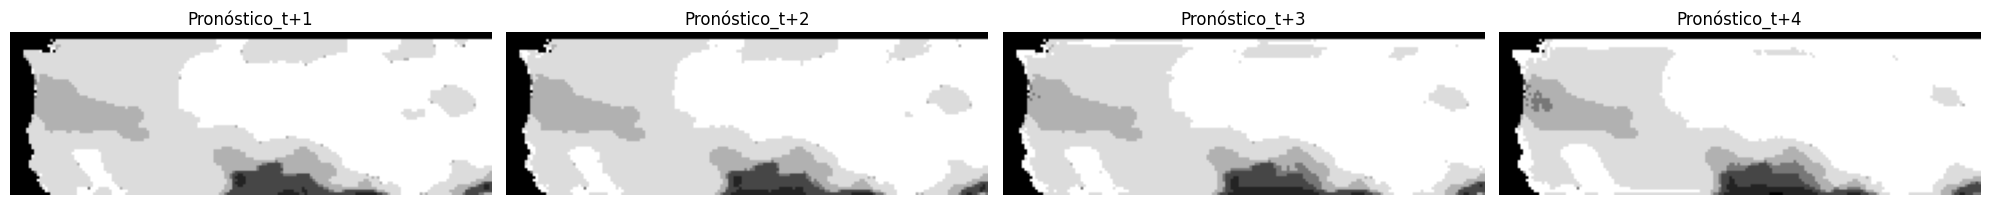

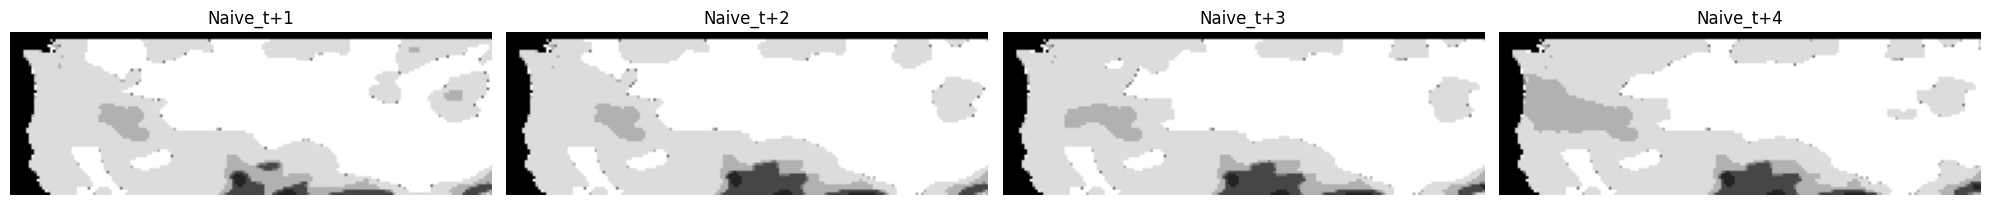

61
190
(371, 4, 61, 190, 1)
(371, 4, 61, 190, 1)
(371, 61, 190, 1)
(367, 4, 61, 190, 1)
COLORSS [[0.        ]
 [0.69411767]
 [0.86274511]
 [1.        ]
 [0.46666667]
 [0.27450982]
 [0.13725491]]
COLORS (7, 1)
COLORSS [[2.31618436e-09]
 [5.73164834e-13]
 [1.91785715e-12]
 ...
 [2.82958599e-08]
 [1.13773993e-07]
 [4.95100539e-05]]
XX
(367, 4, 61, 190, 1)
(367, 4, 61, 190, 1)
(367, 4, 61, 190, 1)
[2.829586e-08]
[0.99595934]
new_data (367, 4, 61, 190, 1)
(10472, 1)
[0]
[253]
HoY (367, 4, 61, 190)
SHAPEE (367, 4, 61, 190)
DCOLORS [  0 220 177 255 119  70  35]
YCOLORS [[  0.]
 [177.]
 [220.]
 [255.]
 [119.]
 [ 70.]
 [ 35.]]
NCOLORS [[  0.]
 [255.]
 [119.]
 [220.]
 [177.]
 [ 70.]
 [ 35.]]
DCOLORS [[  0]
 [220]
 [177]
 [255]
 [119]
 [ 70]
 [ 35]]
XS
new data shape (367, 4, 61, 190, 1)
y_test.shape (367, 4, 61, 190, 1)
new data shape (367, 4, 61, 190, 1)
lengeth x_test: 367
h: 4
rows: 61
cols: 190
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0

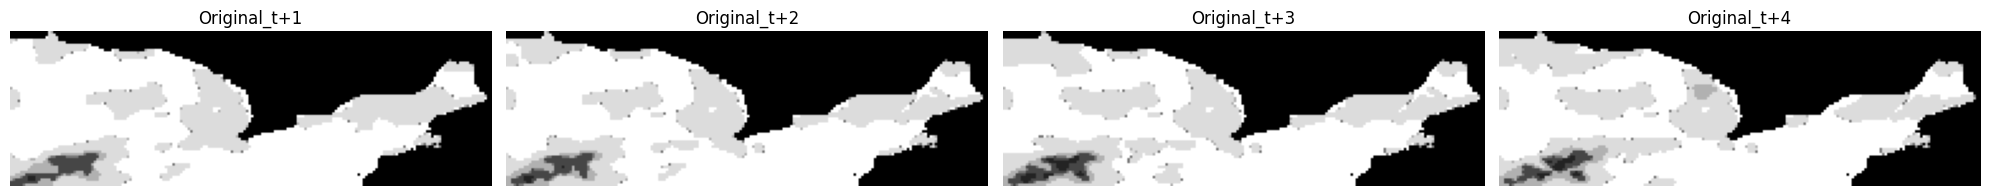

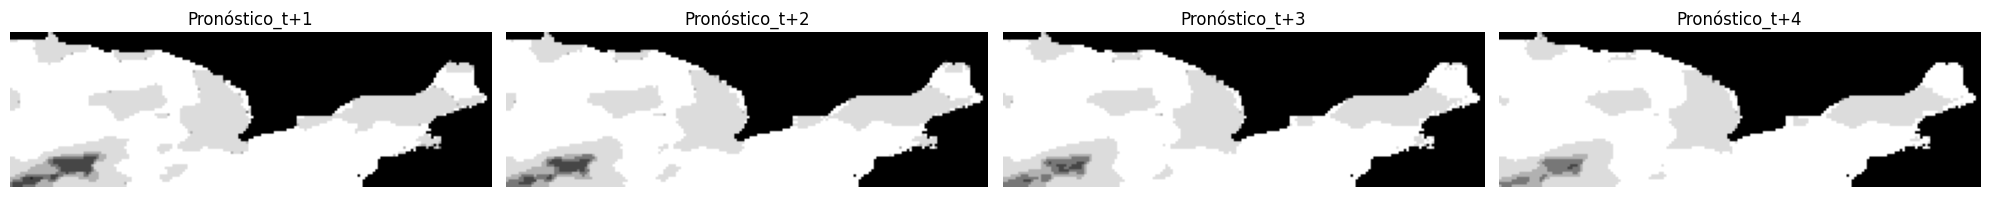

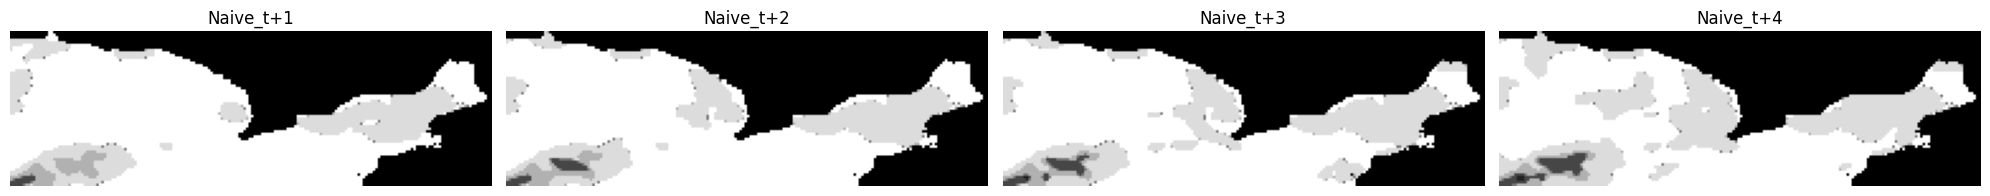

71
180
(371, 4, 71, 180, 1)
(371, 4, 71, 180, 1)
(371, 71, 180, 1)
(367, 4, 71, 180, 1)
COLORSS [[0.        ]
 [1.        ]
 [0.69411767]
 [0.86274511]
 [0.46666667]
 [0.27450982]
 [0.13725491]]
COLORS (7, 1)
COLORSS [[1.02198741e-04]
 [6.03936724e-06]
 [2.74323565e-06]
 ...
 [9.93181786e-08]
 [1.47108460e-06]
 [1.38525269e-04]]
XX
(367, 4, 71, 180, 1)
(367, 4, 71, 180, 1)
(367, 4, 71, 180, 1)
[1.06670935e-16]
[0.9974107]
new_data (367, 4, 71, 180, 1)
(9618, 1)
[0]
[254]
HoY (367, 4, 71, 180)
SHAPEE (367, 4, 71, 180)
DCOLORS [  0 255 177 220 119  70  35]
YCOLORS [[  0.]
 [255.]
 [177.]
 [220.]
 [119.]
 [ 70.]
 [ 35.]]
NCOLORS [[  0.]
 [255.]
 [220.]
 [177.]
 [119.]
 [ 70.]
 [ 35.]]
DCOLORS [[  0]
 [255]
 [177]
 [220]
 [119]
 [ 70]
 [ 35]]
XS
new data shape (367, 4, 71, 180, 1)
y_test.shape (367, 4, 71, 180, 1)
new data shape (367, 4, 71, 180, 1)
lengeth x_test: 367
h: 4
rows: 71
cols: 180
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0

In [53]:
#matriz de confusion
data00 = np.load("DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_0/PredictionsConvolutionLSTM_forecast_61_180_Part0_0_w5.npy")
data01 = np.load("DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_1/PredictionsConvolutionLSTM_forecast_61_190_Part0_1_w5.npy")
data10 = np.load("DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_0/PredictionsConvolutionLSTM_forecast_71_180_Part1_0_w5.npy")
data11 = np.load("DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_1/PredictionsConvolutionLSTM_forecast_71_190_Part1_1_w5.npy")

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    for data in [data00 ,data01, data10, data11]:
        if data is data00:
            parte = parte0_0
            x_test = np.load("DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_0/x_test_mask.npy")
            y_test = np.load("DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_0/y_test_mask.npy")
        elif data is data01:
            parte = parte0_1
            x_test = np.load("DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_1/x_test_mask.npy")
            y_test = np.load("DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_1/y_test_mask.npy")
        elif data is data10:
            parte = parte1_0
            x_test = np.load("DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_0/x_test_mask.npy")
            y_test = np.load("DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_0/y_test_mask.npy")
        elif data is data11:
            parte = parte1_1
            x_test = np.load("DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_1/x_test_mask.npy")
            y_test = np.load("DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_1/y_test_mask.npy")

        classes = np.array([0, 255, 220, 177, 119, 70, 35]) # 255, 220, 177, 119, 70, 35  0
        classes_rgb = np.array([[0,0,0], [35,35,35], [70,70,70], [119,119,119], [177,177,177], [220,220,220], [255,255,255]])
        rows = len(x_test[0,0])
        cols= len(x_test[0,0,0])
        print(rows)
        print(cols)
        h = 4

        print(data.shape)
        print(x_test.shape)
        print(y_test.shape)

        y_test = get_cubes(y_test, h)

        colors = get_colors(x_test[-10,0])
        print("COLORSS", colors)
        print("COLORS", colors.shape)

        colorss = get_colors(data[-10,0])
        print("COLORSS", colorss)

        naive = x_test[:-4]
        data = data[1:-3]

        #y_real = y_test[:, -h:]*255
        new_data = data[:, -h:]
        n_real = naive[:, -h:]*255

        #y_test = y_test[:, -h:]
        naive = naive[:, -h:]

        print("XX")
        print(y_test.shape)
        print(new_data.shape)
        print(n_real.shape)

        print(min(new_data[0,0,60]))
        print(max(new_data[0,0,60]))

        new_data = new_data * 255
        new_data = new_data.astype(np.uint8)

        print("new_data", new_data.shape)
        print(colorss.shape)
        print(min(new_data[0,0,60]))
        print(max(new_data[0,0,60]))

        new_data = new_data.reshape(new_data.shape[:-1])
        print("HoY", new_data.shape)

        aux = []
        for i in new_data:
            aux2 = []
            for j in i:
                #res = cv2.cvtColor(j, cv2.COLOR_GRAY2RGB)
                #res = recolor_greys_image(j, classes)
                #rgb_quantized(res, classes_rgb)
                #res = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)
                res = gray_quantized(j, classes)
                res = recolor_greys_image(res, classes)
                aux2.append(res)
            aux.append(np.array(aux2))


        new_data = np.array(aux)
        print("SHAPEE", new_data.shape)
        color_data = get_colors(new_data[-10,0])
        print("DCOLORS", color_data)
        new_data = new_data.reshape(new_data.shape[0],new_data.shape[1],new_data.shape[2],new_data.shape[3],1)

        y_test = y_test * 255
        naive = naive * 255

        print("YCOLORS", get_colors(y_test[-10,0]))
        print("NCOLORS", get_colors(naive[-10,0]))
        print("DCOLORS", get_colors(new_data[-10,0]))

        print("XS")
        print(f"new data shape {new_data.shape}")
        print(f"y_test.shape {y_test.shape}")
        print(f"new data shape {naive.shape}")

        l_clas = len(classes)

        #print 
        print (f"lengeth x_test: {y_test.shape[0]}")
        print (f"h: {h}")
        print (f"rows: {rows}")
        print (f"cols: {cols}")

        cm_f = np.zeros((l_clas, l_clas), dtype=np.uint64)
        cm_n = np.zeros((l_clas, l_clas), dtype=np.uint64)
        print(cm_f)

        for e in range(y_test.shape[0]):
            for k in range(h):
                for i in range(rows):
                    for j in range(cols):
                        #print(f"e: {e}, k: {k}, i: {i}, j: {j}")
                        pos1 = np.where(classes == y_test[e, k, i, j])[0][0]
                        pos2 = np.where(classes == new_data[e, k, i, j])[0][0]
                        pos3 = np.where(classes == naive[e, k, i, j])[0][0]
                        cm_f[pos1, pos2] += 1
                        cm_n[pos1, pos3] += 1

        print("Matriz de confusión de pronóstico")
        print(cm_f)
        print("Matriz de confusión de naive")
        print(cm_n)

        import pandas as pd

        # Convert cm_f numpy array to pandas DataFrame
        df_cm_f = pd.DataFrame(cm_f)

        print(df_cm_f)

        df_cm_n = pd.DataFrame(cm_n)

        print(df_cm_n)

        # Crear el DataFrame de la primera matriz de confusión como antes
        df_cm_f = pd.DataFrame(cm_f, index=[f'True_{i}' for i in range(len(cm_f))],
                               columns=[f'Pred_{i}' for i in range(len(cm_f[0]))])

        # Crear el DataFrame de la segunda matriz de confusión como antes
        df_cm_n = pd.DataFrame(cm_n, index=[f'True_{i}' for i in range(len(cm_n))],
                               columns=[f'Pred_{i}' for i in range(len(cm_n[0]))])

        # Calcular el desplazamiento necesario para la segunda matriz (longitud de la primera matriz + 2 por la columna vacía)
        offset = df_cm_f.shape[1] + 2

        # Crear un escritor de Excel
        with pd.ExcelWriter("DroughtDatasetMask/dataset/BordesNuevos/61_180"+parte+"/combined_confusion_matrices.xlsx") as writer:
            # Escribir la primera matriz en la hoja de cálculo empezando en la primera columna
            df_cm_f.to_excel(writer, startcol=0, index=True)

            # Escribir la segunda matriz en la hoja de cálculo con un desplazamiento
            df_cm_n.to_excel(writer, startcol=offset, index=True)

        #with pd.ExcelWriter("DroughtDatasetMask/NPY61_180"+parte+"/cm_f_n.xlsx") as writer:
        #    df_cm_f.to_excel(writer, sheet_name='cm_f')
        #    df_cm_n.to_excel(writer, sheet_name='cm_n')


        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=(20,20))
        r = 3
        c = 4
        ac = 1
        pos = 100

        for i in range(h):
            ax = fig.add_subplot(r, c, ac)
            ax.imshow(y_test[pos,i], cmap='gray')
            ax.axis('off')
            ax.set_title('Original_t+{}'.format(i+1))
            ac += 1
        plt.tight_layout()
        plt.show()
        fig = plt.figure(figsize=(20,20))
        for i in range(h):
            ax = fig.add_subplot(r, c, ac)
            ax.imshow(new_data[pos,i], cmap='gray')
            ax.axis('off')
            ax.set_title('Pronóstico_t+{}'.format(i+1))
            ac += 1
        plt.tight_layout()
        plt.show()
        fig = plt.figure(figsize=(20,20))

        for i in range(h):
            ax = fig.add_subplot(r, c, ac)
            ax.imshow(naive[pos,i], cmap='gray')
            ax.axis('off')
            ax.set_title('Naive_t+{}'.format(i+1))
            ac += 1

        # Ajustar el espaciado entre subplots
        plt.subplots_adjust(wspace=.1, hspace=0.05)  # Puedes disminuir estos valores si es necesario
        plt.tight_layout()
        plt.show()



        x = np.array([gray_quantized(i, np.array(categories)) for i in x])
        colors_greys = get_colors(x[1168])
        print(f"Colores {colors_greys}")
        print(x.shape)

        #inicio
        x = np.array([gray_quantized(i, np.array(categories)) for i in x])
        colors_greys = get_colors(x[1168])
        print(f"Colores {colors_greys}")
        print(x.shape)

        x_greys = np.array([recolor_greys_image(img, categories) for img in x])
        x = x_greys.astype('float32') / 255
        print(get_colors(x[1168]))
        print(x.shape)

        x_2 = agroup_window(x, window)
        print(x_2.shape)
        x_train = x_2[:int(len(x_2)*.7)]
        x_test = x_2[int(len(x_2)*.7):]
        x_validation = x_train[int(len(x_train)*.8):]
        x_train = x_train[:int(len(x_train)*.8)]

        x_train = x_train.reshape(len(x_train), window, rows, cols, channels)
        x_validation = x_validation.reshape(len(x_validation), window, rows, cols, channels)
        x_test = x_test.reshape(len(x_test), window, rows, cols, channels)

        print("Forma de datos de entrenamiento: {}".format(x_train.shape))
        print("Forma de datos de validación: {}".format(x_validation.shape))
        print("Forma de datos de pruebas: {}".format(x_test.shape))

        x_train, y_train = create_shifted_frames_2(x_train)
        x_validation, y_validation = create_shifted_frames_2(x_validation)
        x_test, y_test = create_shifted_frames_2(x_test)

        print("Training dataset shapes: {}, {}".format(x_train.shape, y_train.shape))
        print("Validation dataset shapes: {}, {}".format(x_validation.shape, y_validation.shape))
        print("Test dataset shapes: {}, {}".format(x_test.shape, y_test.shape))

        np.save("DroughtDatasetMask/NPY61_180"+parte+"/x_test_mask.npy", x_test)
        np.save("DroughtDatasetMask/NPY61_180"+parte+"/y_test_mask.npy", y_test)
        np.save("DroughtDatasetMask/NPY61_180"+parte+"/x_train_mask.npy", x_train)
        np.save("DroughtDatasetMask/NPY61_180"+parte+"/y_train_mask.npy", y_train)
        np.save("DroughtDatasetMask/NPY61_180"+parte+"/x_validation_mask.npy", x_validation)
        np.save("DroughtDatasetMask/NPY61_180"+parte+"/y_validation_mask.npy", y_validation)

        #Construction of Convolutional LSTM network
        inp = keras.layers.Input(shape=(None, *x_train.shape[2:]))
        #It will be constructed a 3 ConvLSTM2D layers with batch normalization,
        #Followed by a Conv3D layer for the spatiotemporal outputs.
        m = keras.layers.ConvLSTM2D(16, (5,5), padding= "same", return_sequences= True, activation= "relu")(inp)
        m = keras.layers.BatchNormalization()(m)
        m = keras.layers.ConvLSTM2D(16, (5,5), padding= "same", return_sequences= True, activation= "relu")(m)
        m = keras.layers.BatchNormalization()(m)
        m = keras.layers.ConvLSTM2D(16, (3,3), padding= "same", activation= "relu")(m)
        m = keras.layers.Conv2D(channels, (3,3), activation= "sigmoid", padding= "same")(m)
        model = keras.models.Model(inp, m)
        model.compile(loss= "binary_crossentropy", optimizer= "Adam")
        print(model.summary())
        #Callbacks
        early_stopping = keras.callbacks.EarlyStopping(monitor= "val_loss", patience= 6, restore_best_weights= True)
        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor= "val_loss", patience= 6)
        #Define moifiable training hyperparameters
        epochs = 30
        batch_size = 2
        #Model training
        model.fit(
            x_train, y_train,
            batch_size= batch_size,
            epochs= epochs,
            validation_data= (x_validation, y_validation),
            callbacks= [early_stopping, reduce_lr]
        )

        #Guardar el modelo
        model.save("DroughtDatasetMask/NPY61_180"+parte+"/ConvLSTM2D_Mask61_180.h5")    

        print (f"lengeth x_test: {len(x_test)}")
        imagenInicial = np.random.choice(range(len(x_test)), size= 1)[0]
        print(imagenInicial)

        example = x_test[imagenInicial]

        print(example.shape)

        err = model.evaluate(x_test, y_test, batch_size= 2)
        print("El error del modelo es: {}".format(err))
        preds = model.predict(x_test, batch_size= 2)
        print(preds.shape)
        x_test_new = add_last(x_test, preds[:])
        preds2 = model.predict(x_test_new, batch_size= 2)
        #print(preds2.shape)
        x_test_new = add_last(x_test_new, preds2[:])
        preds3 = model.predict(x_test_new, batch_size= 2)
        x_test_new = add_last(x_test_new, preds3[:])
        preds4 = model.predict(x_test_new, batch_size= 2)
        res_forecast = add_last(x_test_new, preds4[:])
        print("PREDSS",res_forecast.shape)

        np.save("DroughtDatasetMask/NPY61_180"+parte+"/PredictionsConvolutionLSTM_forecast_61_180_"+parte+"_w5.npy", res_forecast)  #Guardar el vector de predicciones

        modelos = []
        #agregar pred a modelos
        modelos.append(preds)
        modelos.append(preds2)
        modelos.append(preds3)
        modelos.append(preds4)


        print("Preds" , preds.shape)
        print("Preds2" , preds2.shape)
        print("Preds3" , preds3.shape)
        print("Preds4" , preds4.shape)
        print("Res_forecast" , res_forecast.shape)
        print("x_test" , x_test.shape)
        print("x_test_new" , x_test_new.shape)
        print("y_test" , y_test.shape)

        # Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()
        plt.imshow(preds[0].squeeze(), cmap='gray')
        plt.title("First Predicted Image")
        plt.axis('off')
        plt.show()

        #matriz de confusion
        classes = np.array([0, 255, 220, 177, 119, 70, 35]) # 255, 220, 177, 119, 70, 35  0
        classes_rgb = np.array([[0,0,0], [35,35,35], [70,70,70], [119,119,119], [177,177,177], [220,220,220], [255,255,255]])
        rows = len(x_test[0,0])
        cols= len(x_test[0,0,0])
        print(rows)
        print(cols)
        h = 4

        print(data.shape)
        print(x_test.shape)
        print(y_test.shape)

        y_test = get_cubes(y_test, h)

        colors = get_colors(x_test[-10,0])
        print("COLORSS", colors)
        print("COLORS", colors.shape)

        colorss = get_colors(data[-10,0])
        print("COLORSS", colorss)

        naive = x_test[:-4]
        data = data[1:-3]

        #y_real = y_test[:, -h:]*255
        new_data = data[:, -h:]
        n_real = naive[:, -h:]*255

        #y_test = y_test[:, -h:]
        naive = naive[:, -h:]

        print("XX")
        print(y_test.shape)
        print(new_data.shape)
        print(n_real.shape)

        print(min(new_data[0,0,60]))
        print(max(new_data[0,0,60]))

        new_data = new_data * 255
        new_data = new_data.astype(np.uint8)

        print("new_data", new_data.shape)
        print(colorss.shape)
        print(min(new_data[0,0,60]))
        print(max(new_data[0,0,60]))

        new_data = new_data.reshape(new_data.shape[:-1])
        print("HoY", new_data.shape)

        aux = []
        for i in new_data:
            aux2 = []
            for j in i:
                #res = cv2.cvtColor(j, cv2.COLOR_GRAY2RGB)
                #res = recolor_greys_image(j, classes)
                #rgb_quantized(res, classes_rgb)
                #res = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)
                res = gray_quantized(j, classes)
                res = recolor_greys_image(res, classes)
                aux2.append(res)
            aux.append(np.array(aux2))


        new_data = np.array(aux)
        print("SHAPEE", new_data.shape)
        color_data = get_colors(new_data[-10,0])
        print("DCOLORS", color_data)
        new_data = new_data.reshape(new_data.shape[0],new_data.shape[1],new_data.shape[2],new_data.shape[3],1)

        y_test = y_test * 255
        naive = naive * 255

        print("YCOLORS", get_colors(y_test[-10,0]))
        print("NCOLORS", get_colors(naive[-10,0]))
        print("DCOLORS", get_colors(new_data[-10,0]))

        print("XS")
        print(f"new data shape {new_data.shape}")
        print(f"y_test.shape {y_test.shape}")
        print(f"new data shape {naive.shape}")

        l_clas = len(classes)

        #print 
        print (f"lengeth x_test: {y_test.shape[0]}")
        print (f"h: {h}")
        print (f"rows: {rows}")
        print (f"cols: {cols}")

        cm_f = np.zeros((l_clas, l_clas), dtype=np.uint64)
        cm_n = np.zeros((l_clas, l_clas), dtype=np.uint64)
        print(cm_f)

        for e in range(y_test.shape[0]):
            for k in range(h):
                for i in range(rows):
                    for j in range(cols):
                        #print(f"e: {e}, k: {k}, i: {i}, j: {j}")
                        pos1 = np.where(classes == y_test[e, k, i, j])[0][0]
                        pos2 = np.where(classes == new_data[e, k, i, j])[0][0]
                        pos3 = np.where(classes == naive[e, k, i, j])[0][0]
                        cm_f[pos1, pos2] += 1
                        cm_n[pos1, pos3] += 1

        print("Matriz de confusión de pronóstico")
        print(cm_f)
        print("Matriz de confusión de naive")
        print(cm_n)

        import pandas as pd

        # Convert cm_f numpy array to pandas DataFrame
        df_cm_f = pd.DataFrame(cm_f)

        print(df_cm_f)

        df_cm_n = pd.DataFrame(cm_n)

        print(df_cm_n)

        # Crear el DataFrame de la primera matriz de confusión como antes
        df_cm_f = pd.DataFrame(cm_f, index=[f'True_{i}' for i in range(len(cm_f))],
                               columns=[f'Pred_{i}' for i in range(len(cm_f[0]))])

        # Crear el DataFrame de la segunda matriz de confusión como antes
        df_cm_n = pd.DataFrame(cm_n, index=[f'True_{i}' for i in range(len(cm_n))],
                               columns=[f'Pred_{i}' for i in range(len(cm_n[0]))])

        # Calcular el desplazamiento necesario para la segunda matriz (longitud de la primera matriz + 2 por la columna vacía)
        offset = df_cm_f.shape[1] + 2

        # Crear un escritor de Excel
        with pd.ExcelWriter("DroughtDatasetMask/NPY61_180"+parte+"/combined_confusion_matrices.xlsx") as writer:
            # Escribir la primera matriz en la hoja de cálculo empezando en la primera columna
            df_cm_f.to_excel(writer, startcol=0, index=True)

            # Escribir la segunda matriz en la hoja de cálculo con un desplazamiento
            df_cm_n.to_excel(writer, startcol=offset, index=True)

        #with pd.ExcelWriter("DroughtDatasetMask/NPY61_180"+parte+"/cm_f_n.xlsx") as writer:
        #    df_cm_f.to_excel(writer, sheet_name='cm_f')
        #    df_cm_n.to_excel(writer, sheet_name='cm_n')


        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=(20,20))
        r = 3
        c = 4
        ac = 1
        pos = 100

        for i in range(h):
            ax = fig.add_subplot(r, c, ac)
            ax.imshow(y_test[pos,i], cmap='gray')
            ax.axis('off')
            ax.set_title('Original_t+{}'.format(i+1))
            ac += 1
        plt.tight_layout()
        plt.show()
        fig = plt.figure(figsize=(20,20))
        for i in range(h):
            ax = fig.add_subplot(r, c, ac)
            ax.imshow(new_data[pos,i], cmap='gray')
            ax.axis('off')
            ax.set_title('Pronóstico_t+{}'.format(i+1))
            ac += 1
        plt.tight_layout()
        plt.show()
        fig = plt.figure(figsize=(20,20))

        for i in range(h):
            ax = fig.add_subplot(r, c, ac)
            ax.imshow(naive[pos,i], cmap='gray')
            ax.axis('off')
            ax.set_title('Naive_t+{}'.format(i+1))
            ac += 1

        # Ajustar el espaciado entre subplots
        plt.subplots_adjust(wspace=.1, hspace=0.05)  # Puedes disminuir estos valores si es necesario
        plt.tight_layout()
        plt.show()


prueba fin

In [13]:
x = np.array([gray_quantized(i, np.array(categories)) for i in x])
colors_greys = get_colors(x[1168])
print(f"Colores {colors_greys}")
print(x.shape)

Colores [  0 255 223 190 215 172 176 212 226 224 169 194  78  69  83 168 181 222
 200 217 177 148 165 213 210 184 218 219  76 139 204 113 198 175 156 133
 205 225 216  90  89 162 193 211 117  82 159 154  70  99 174 187 209 214
 110  98 126 170 220 189 173 182 178 197  72  71 104 206 208 138 203 143
 161 221 119 127 150 188 166  68  81  62  52  38  36  48  67  66  34  59
  64  57  50  40 180  77 101 201 167 130  60]
(1240, 61, 180)


In [14]:
x_greys = np.array([recolor_greys_image(img, categories) for img in x])
x = x_greys.astype('float32') / 255
print(get_colors(x[1168]))
print(x.shape)

[0.         1.         0.86274511 0.69411767 0.27450982 0.46666667
 0.13725491]
(1240, 61, 180)


Displaying frames for example 127


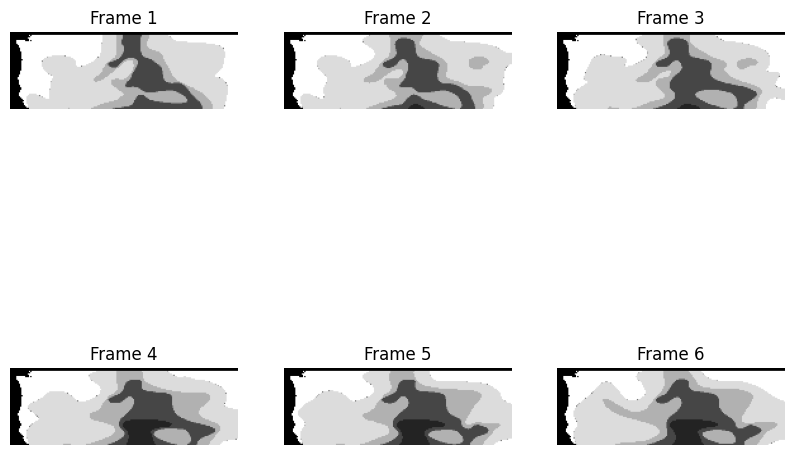

In [15]:
#Mostrar imágenes
fig, axes = plt.subplots(2, 3, figsize= (10,8))

data_choise = np.random.choice(range(len(x)), size= 1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(x[data_choise+idx]), cmap='gray')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
print("Displaying frames for example {}".format(data_choise))
plt.show()

In [59]:
x_2 = agroup_window(x, window)
print(x_2.shape)
x_train = x_2[:int(len(x_2)*.7)]
x_test = x_2[int(len(x_2)*.7):]
x_validation = x_train[int(len(x_train)*.8):]
x_train = x_train[:int(len(x_train)*.8)]

(1236, 5, 61, 180)


In [60]:
x_train = x_train.reshape(len(x_train), window, rows, cols, channels)
x_validation = x_validation.reshape(len(x_validation), window, rows, cols, channels)
x_test = x_test.reshape(len(x_test), window, rows, cols, channels)

print("Forma de datos de entrenamiento: {}".format(x_train.shape))
print("Forma de datos de validación: {}".format(x_validation.shape))
print("Forma de datos de pruebas: {}".format(x_test.shape))

Forma de datos de entrenamiento: (692, 5, 61, 180, 1)
Forma de datos de validación: (173, 5, 61, 180, 1)
Forma de datos de pruebas: (371, 5, 61, 180, 1)


In [61]:
x_train, y_train = create_shifted_frames_2(x_train)
x_validation, y_validation = create_shifted_frames_2(x_validation)
x_test, y_test = create_shifted_frames_2(x_test)

print("Training dataset shapes: {}, {}".format(x_train.shape, y_train.shape))
print("Validation dataset shapes: {}, {}".format(x_validation.shape, y_validation.shape))
print("Test dataset shapes: {}, {}".format(x_test.shape, y_test.shape))

Training dataset shapes: (692, 4, 61, 180, 1), (692, 61, 180, 1)
Validation dataset shapes: (173, 4, 61, 180, 1), (173, 61, 180, 1)
Test dataset shapes: (371, 4, 61, 180, 1), (371, 61, 180, 1)


In [62]:
np.save("DroughtDatasetMask/NPY61_180Part0_0/x_test_mask.npy", x_test)
np.save("DroughtDatasetMask/NPY61_180Part0_0/y_test_mask.npy", y_test)

In [63]:
#strategy
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    #Construction of Convolutional LSTM network
    inp = keras.layers.Input(shape=(None, *x_train.shape[2:]))
    #It will be constructed a 3 ConvLSTM2D layers with batch normalization,
    #Followed by a Conv3D layer for the spatiotemporal outputs.
    m = keras.layers.ConvLSTM2D(16, (5,5), padding= "same", return_sequences= True, activation= "relu")(inp)
    m = keras.layers.BatchNormalization()(m)
    m = keras.layers.ConvLSTM2D(16, (5,5), padding= "same", return_sequences= True, activation= "relu")(m)
    m = keras.layers.BatchNormalization()(m)
    m = keras.layers.ConvLSTM2D(16, (3,3), padding= "same", activation= "relu")(m)
    m = keras.layers.Conv2D(channels, (3,3), activation= "sigmoid", padding= "same")(m)
    model = keras.models.Model(inp, m)
    model.compile(loss= "binary_crossentropy", optimizer= "Adam")
    print(model.summary())
    #Callbacks
    early_stopping = keras.callbacks.EarlyStopping(monitor= "val_loss", patience= 6, restore_best_weights= True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor= "val_loss", patience= 4)
    #Define moifiable training hyperparameters
    epochs = 200
    batch_size = 16
    #Model training
    model.fit(
        x_train, y_train,
        batch_size= batch_size,
        epochs= epochs,
        validation_data= (x_validation, y_validation),
        callbacks= [early_stopping, reduce_lr]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

2023-11-29 13:38:11.484740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-11-29 13:38:11.762076: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-11-29 13:38:14.330633: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55e003dfde80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-29 13:38:14.330663: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-29 13:38:14.330667: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-29 13:38:1

44/44 [==============================] - 25s 164ms/step - loss: 0.3084 - val_loss: 0.6253 - lr: 0.0010
Epoch 2/200
44/44 [==============================] - 6s 130ms/step - loss: 0.2684 - val_loss: 0.6163 - lr: 0.0010
Epoch 3/200
44/44 [==============================] - 6s 126ms/step - loss: 0.2654 - val_loss: 0.5965 - lr: 0.0010
Epoch 4/200
44/44 [==============================] - 6s 126ms/step - loss: 0.2641 - val_loss: 0.5627 - lr: 0.0010
Epoch 5/200
44/44 [==============================] - 6s 128ms/step - loss: 0.2641 - val_loss: 0.5401 - lr: 0.0010
Epoch 6/200
44/44 [==============================] - 6s 126ms/step - loss: 0.2632 - val_loss: 0.4999 - lr: 0.0010
Epoch 7/200
44/44 [==============================] - 6s 127ms/step - loss: 0.2628 - val_loss: 0.4483 - lr: 0.0010
Epoch 8/200
44/44 [==============================] - 6s 128ms/step - loss: 0.2629 - val_loss: 0.3943 - lr: 0.0010
Epoch 9/200
44/44 [==============================] - 6s 126ms/step - loss: 0.2629 - val_loss: 0.356

In [64]:
#Guardar el modelo
model.save("DroughtDatasetMask/NPY61_180Part0_0/ConvLSTM2D_Mask61_180.h5")

In [65]:
#cargar el modelo
model = keras.models.load_model("DroughtDatasetMask/NPY61_180Part0_0/ConvLSTM2D_Mask61_180.h5")

In [66]:
print (f"lengeth x_test: {len(x_test)}")
imagenInicial = np.random.choice(range(len(x_test)), size= 1)[0]
print(imagenInicial)

lengeth x_test: 371
176


(4, 61, 180, 1)
186/186 [==============================] - 3s 13ms/step - loss: 0.2727
El error del modelo es: 0.2726821005344391
186/186 [==============================] - 2s 11ms/step
(371, 61, 180, 1)
data: (371, 4, 61, 180, 1) y new_val: (371, 61, 180, 1)
x_test_new: (371, 3, 61, 180, 1)
CX (371, 4, 61, 180, 1)
186/186 [==============================] - 2s 11ms/step
data: (371, 4, 61, 180, 1) y new_val: (371, 61, 180, 1)
x_test_new: (371, 3, 61, 180, 1)
CX (371, 4, 61, 180, 1)
186/186 [==============================] - 2s 11ms/step
data: (371, 4, 61, 180, 1) y new_val: (371, 61, 180, 1)
x_test_new: (371, 3, 61, 180, 1)
CX (371, 4, 61, 180, 1)
186/186 [==============================] - 2s 10ms/step
data: (371, 4, 61, 180, 1) y new_val: (371, 61, 180, 1)
x_test_new: (371, 3, 61, 180, 1)
CX (371, 4, 61, 180, 1)
PREDSS (371, 4, 61, 180, 1)
Preds (371, 61, 180, 1)
Preds2 (371, 61, 180, 1)
Preds3 (371, 61, 180, 1)
Preds4 (371, 61, 180, 1)
Res_forecast (371, 4, 61, 180, 1)
x_test (371, 4,

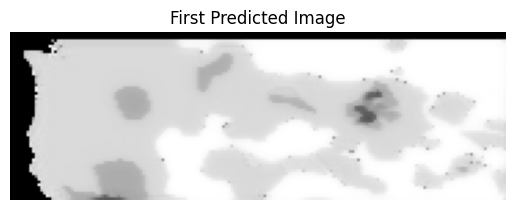

In [67]:
example = x_test[imagenInicial]

print(example.shape)

err = model.evaluate(x_test, y_test, batch_size= 2)
print("El error del modelo es: {}".format(err))
preds = model.predict(x_test, batch_size= 2)
print(preds.shape)
x_test_new = add_last(x_test, preds[:])
preds2 = model.predict(x_test_new, batch_size= 2)
#print(preds2.shape)
x_test_new = add_last(x_test_new, preds2[:])
preds3 = model.predict(x_test_new, batch_size= 2)
x_test_new = add_last(x_test_new, preds3[:])
preds4 = model.predict(x_test_new, batch_size= 2)
res_forecast = add_last(x_test_new, preds4[:])
print("PREDSS",res_forecast.shape)

np.save("DroughtDatasetMask/NPY61_180Part0_0/PredictionsConvolutionLSTM_forecast_61_180_w5.npy", res_forecast)  #Guardar el vector de predicciones

modelos = []
#agregar pred a modelos
modelos.append(preds)
modelos.append(preds2)
modelos.append(preds3)
modelos.append(preds4)


print("Preds" , preds.shape)
print("Preds2" , preds2.shape)
print("Preds3" , preds3.shape)
print("Preds4" , preds4.shape)
print("Res_forecast" , res_forecast.shape)
print("x_test" , x_test.shape)
print("x_test_new" , x_test_new.shape)
print("y_test" , y_test.shape)

# Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()
plt.imshow(preds[0].squeeze(), cmap='gray')
plt.title("First Predicted Image")
plt.axis('off')
plt.show()



In [68]:
data = np.load("DroughtDatasetMask/NPY61_180Part0_0/PredictionsConvolutionLSTM_forecast_61_180_w5.npy")
x_test = np.load("DroughtDatasetMask/NPY61_180Part0_0/x_test_mask.npy")
y_test = np.load("DroughtDatasetMask/NPY61_180Part0_0/y_test_mask.npy")

In [69]:
classes = np.array([0, 255, 220, 177, 119, 70, 35]) # 255, 220, 177, 119, 70, 35  0
classes_rgb = np.array([[0,0,0], [35,35,35], [70,70,70], [119,119,119], [177,177,177], [220,220,220], [255,255,255]])
rows = len(x_test[0,0])
cols= len(x_test[0,0,0])
print(rows)
print(cols)
h = 4

61
180


In [70]:
print(data.shape)
print(x_test.shape)
print(y_test.shape)

y_test = get_cubes(y_test, h)

(371, 4, 61, 180, 1)
(371, 4, 61, 180, 1)
(371, 61, 180, 1)
(367, 4, 61, 180, 1)


In [71]:
colors = get_colors(x_test[-10,0])
print("COLORSS", colors)
print("COLORS", colors.shape)

colorss = get_colors(data[-10,0])
print("COLORSS", colorss)

COLORSS [[0.        ]
 [0.69411767]
 [0.86274511]
 [1.        ]
 [0.46666667]
 [0.27450982]
 [0.13725491]]
COLORS (7, 1)
COLORSS [[4.48246114e-03]
 [7.32685614e-04]
 [2.29718644e-04]
 ...
 [6.56942666e-01]
 [7.12850332e-01]
 [7.11768985e-01]]


In [72]:
naive = x_test[:-4]
data = data[1:-3]

#y_real = y_test[:, -h:]*255
new_data = data[:, -h:]
n_real = naive[:, -h:]*255

#y_test = y_test[:, -h:]
naive = naive[:, -h:]

In [73]:
print("XX")
print(y_test.shape)
print(new_data.shape)
print(n_real.shape)

print(min(new_data[0,0,60]))
print(max(new_data[0,0,60]))

XX
(367, 4, 61, 180, 1)
(367, 4, 61, 180, 1)
(367, 4, 61, 180, 1)
[6.367478e-05]
[0.991524]


In [74]:
new_data = new_data * 255
new_data = new_data.astype(np.uint8)

print("HEY", new_data.shape)
print(colorss.shape)
print(min(new_data[0,0,60]))
print(max(new_data[0,0,60]))

HEY (367, 4, 61, 180, 1)
(9993, 1)
[0]
[252]


In [75]:

new_data = new_data.reshape(new_data.shape[:-1])
print("HoY", new_data.shape)

HoY (367, 4, 61, 180)


In [76]:

aux = []
for i in new_data:
    aux2 = []
    for j in i:
        #res = cv2.cvtColor(j, cv2.COLOR_GRAY2RGB)
        #res = recolor_greys_image(j, classes)
        #rgb_quantized(res, classes_rgb)
        #res = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)
        res = gray_quantized(j, classes)
        res = recolor_greys_image(res, classes)
        aux2.append(res)
    aux.append(np.array(aux2))

In [77]:


new_data = np.array(aux)
print("SHAPEE", new_data.shape)
color_data = get_colors(new_data[-10,0])
print("DCOLORS", color_data)
new_data = new_data.reshape(new_data.shape[0],new_data.shape[1],new_data.shape[2],new_data.shape[3],1)

SHAPEE (367, 4, 61, 180)
DCOLORS [  0 119 220 255 177  35  70]


In [78]:
#y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2]))*255
#naive = naive.reshape((naive.shape[0], naive.shape[1], naive.shape[2])) * 255

#plt.imshow(y_test[0,0], cmap="gray")
#plt.show()


#plt.imshow(new_data[0,0], cmap="gray")
#plt.show()


#plt.imshow(naive[0,0], cmap="gray")
#plt.show()

In [79]:
y_test = y_test * 255
naive = naive * 255

print("YCOLORS", get_colors(y_test[-10,0]))
print("NCOLORS", get_colors(naive[-10,0]))

print("XS")
print(new_data.shape)
print(y_test.shape)
print(naive.shape)

l_clas = len(classes)

YCOLORS [[  0.]
 [177.]
 [220.]
 [255.]
 [119.]
 [ 70.]
 [ 35.]]
NCOLORS [[  0.]
 [177.]
 [220.]
 [255.]
 [119.]
 [ 70.]
 [ 35.]]
XS
(367, 4, 61, 180, 1)
(367, 4, 61, 180, 1)
(367, 4, 61, 180, 1)


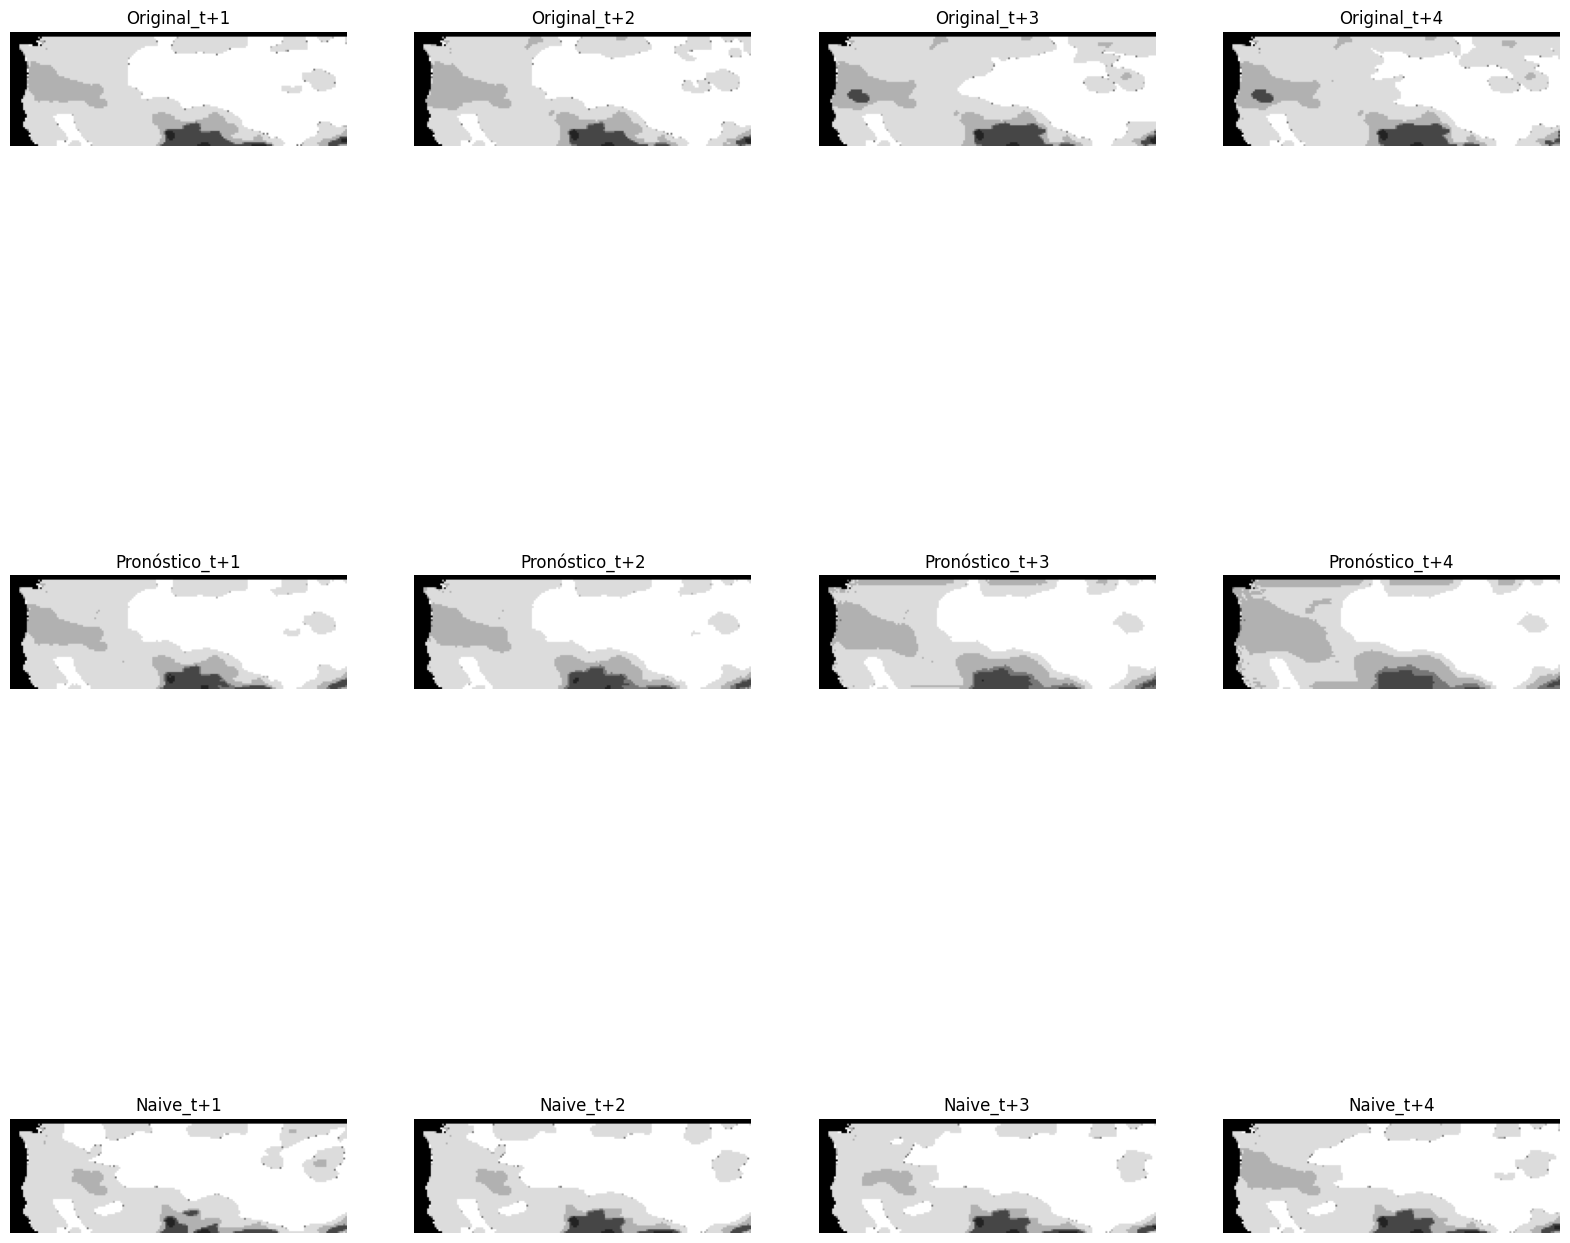

In [80]:

fig = plt.figure(figsize=(20,20))
r = 3
c = 4
ac = 1
pos = 100
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(y_test[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Original_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(new_data[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Pronóstico_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(naive[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Naive_t+{}'.format(i+1))

plt.show()

In [81]:
#print 
print (f"lengeth x_test: {y_test.shape[0]}")
print (f"h: {h}")
print (f"rows: {rows}")
print (f"cols: {cols}")

lengeth x_test: 367
h: 4
rows: 61
cols: 180


In [ ]:
cm_f = np.zeros((l_clas, l_clas), dtype=np.uint64)
cm_n = np.zeros((l_clas, l_clas), dtype=np.uint64)
print(cm_f)

In [82]:
for e in range(y_test.shape[0]):
    for k in range(h):
        for i in range(rows):
            for j in range(cols):
                #print(f"e: {e}, k: {k}, i: {i}, j: {j}")
                pos1 = np.where(classes == y_test[e, k, i, j])[0][0]
                pos2 = np.where(classes == new_data[e, k, i, j])[0][0]
                pos3 = np.where(classes == naive[e, k, i, j])[0][0]
                cm_f[pos1, pos2] += 1
                cm_n[pos1, pos3] += 1

print("Matriz de confusión de pronóstico")
print(cm_f)
print("Matriz de confusión de naive")
print(cm_n)

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Matriz de confusión de pronóstico
[[1552664       0       0       0       0      49    1899]
 [      2 5403221  357178   27815     402     124      45]
 [      0  375870 3967807  965103   10857    1506      16]
 [      7    9659   84207 1557694  187147   38564     636]
 [     16    5220   12102   23244   87078    7189     336]
 [      5       0    1103   57498  227580  829424   17226]
 [      0       0      17    1355    2918   62507  241350]]
Matriz de confusión de naive
[[1554612       0       0       0       0       0       0]
 [      0 5000370  754324   21444   12489     140      20]
 [      0  730908 4210346  345356   13470   20831     248]
 [      0   18848  357374 1300152   28194  167814    5532]
 [      0   10107   14712   28936   59742   20332    1356]
 [      0     340   25862  166883   19618  864248   55885]
 [      0      20     612    6643    1148   54870

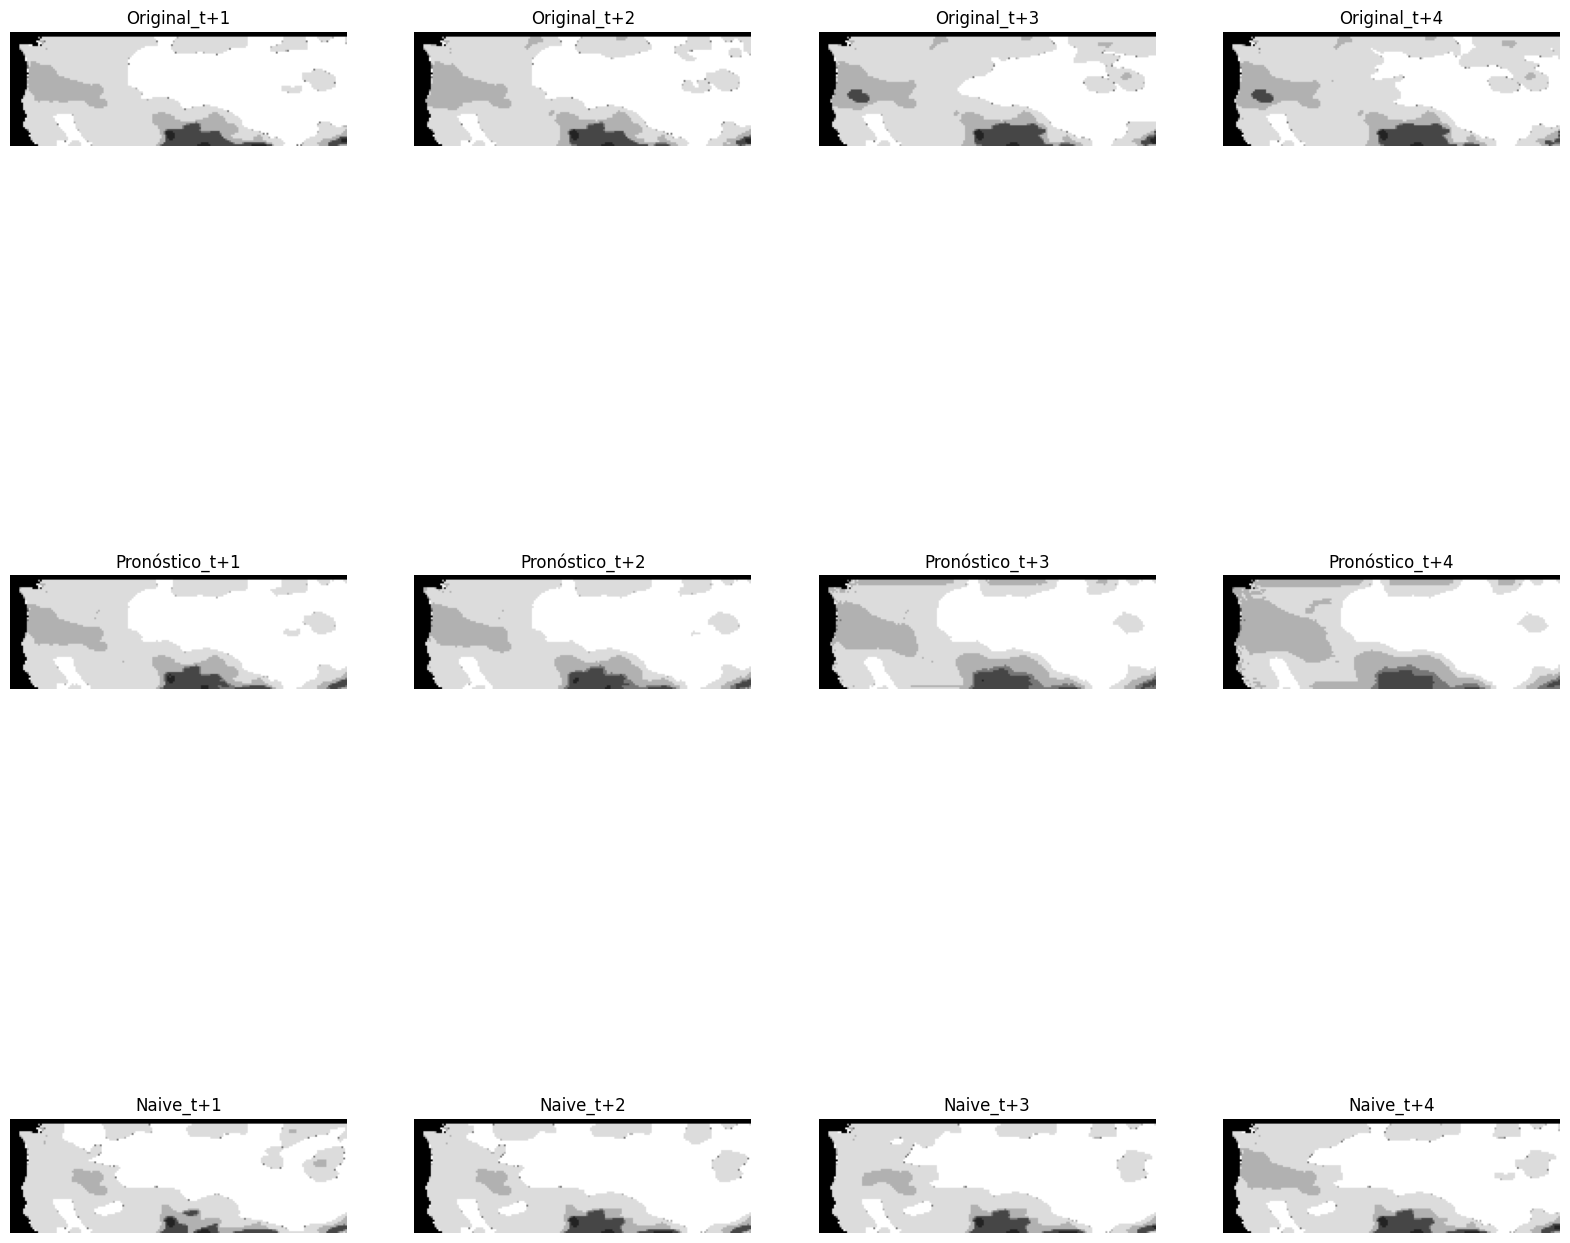

In [83]:
fig = plt.figure(figsize=(20,20))
r = 3
c = 4
ac = 1
pos = 100
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(y_test[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Original_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(new_data[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Pronóstico_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(naive[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Naive_t+{}'.format(i+1))

plt.show()

## not working

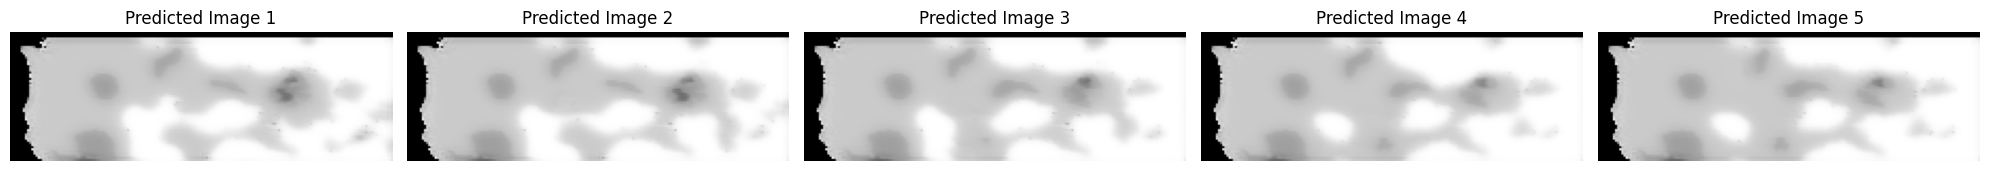

In [91]:
n_images = 5  # Define cuántas imágenes quieres mostrar
fig, axes = plt.subplots(1, n_images, figsize=(20, 4))
for i in range(n_images):
    for j in range(len(modelos)):
        # Asegúrate de que cada imagen es una matriz 2D al usar squeeze()
        axes[i].imshow(modelos[j][i].squeeze(), cmap='gray')
        axes[i].set_title(f"Predicted Image {i+1}")
        axes[i].axis('off')
plt.tight_layout()
plt.show()

Shape of predicted: (61, 180, 1)
Shape of predicted image: (61, 180, 1)
Shape of predicted: (61, 180, 1)
Shape of predicted image: (61, 180, 1)
Shape of predicted: (61, 180, 1)
Shape of predicted image: (61, 180, 1)
Shape of predicted: (61, 180, 1)
Shape of predicted image: (61, 180, 1)
Shape of predicted: (61, 180, 1)
Shape of predicted image: (61, 180, 1)


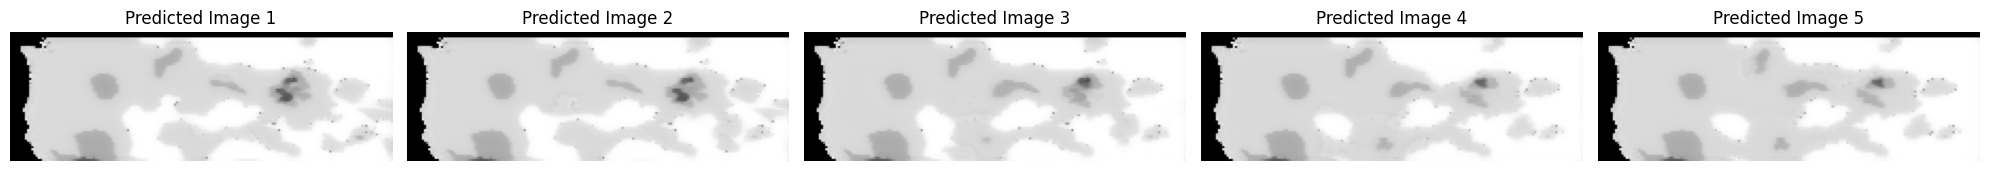

In [92]:
n_images = 5  # Define cuántas imágenes quieres mostrar
fig, axes = plt.subplots(1, n_images, figsize=(20, 4))
for i in range(n_images):
    #Asegúrate de que cada imagen es una matriz 2D al usar squeeze()
    print(f"Shape of predicted: {preds[i].shape}")
    axes[i].imshow(preds[i].squeeze(), cmap='gray')
    print(f"Shape of predicted image: {preds[i].shape}")
    axes[i].set_title(f"Predicted Image {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [94]:
print(range(len(x_test)))

range(0, 4)


In [87]:
imagenInicial = np.random.choice(range(len(x_test)), size= 1)[0]
print(imagenInicial)

194


(4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 23ms/step


example (4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 23ms/step
example (4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 22ms/step
example (4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 20ms/step
example (4, 61, 180, 1)
(1, 61, 180, 1)


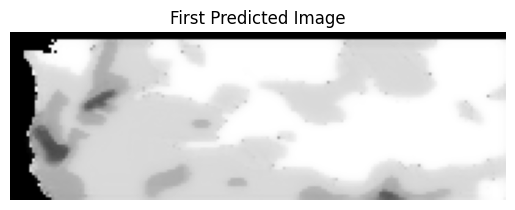

In [88]:

example = x_test[imagenInicial]
#frames = example[:4, ...]
#original_frames = example[4:, ...]
print(example.shape)
#print(frames.shape)
#print(original_frames.shape)
for _ in range(horizon):
    print(example.shape)
    new_prediction = model.predict(example.reshape(1,*example.shape[0:]))
    example = np.concatenate((example[1:], new_prediction), axis=0)
    print(f"example {example.shape}")
predictions = example[:-3]
print(predictions.shape)
# Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()
plt.imshow(predictions[0].squeeze(), cmap='gray')
plt.title("First Predicted Image")
plt.axis('off')
plt.show()

(4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 23ms/step
example (4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 20ms/step
example (4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 21ms/step
example (4, 61, 180, 1)
(4, 61, 180, 1)
1/1 [==============================] - 0s 20ms/step
example (4, 61, 180, 1)
(1, 61, 180, 1)


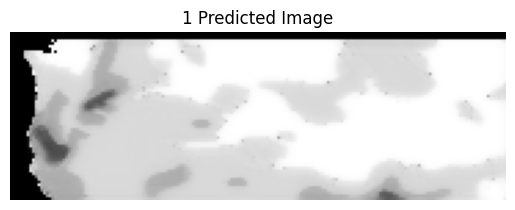

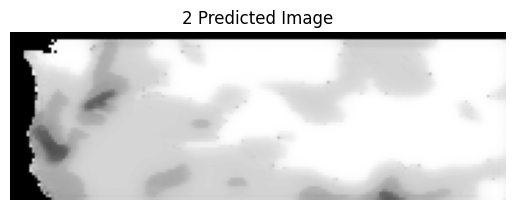

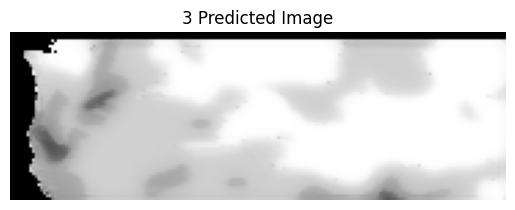

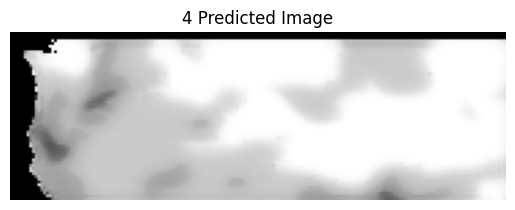

In [89]:

example = x_test[imagenInicial]
#frames = example[:4, ...]
#original_frames = example[4:, ...]
print(example.shape)
#print(frames.shape)
#print(original_frames.shape)
for _ in range(horizon):
    print(example.shape)
    new_prediction = model.predict(example.reshape(1,*example.shape[0:]))
    example = np.concatenate((example[1:], new_prediction), axis=0)
    print(f"example {example.shape}")
predictions = example[:-3]
print(predictions.shape)
# Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()

for i in range(horizon):
    plt.imshow(example[i].squeeze(), cmap='gray')
    plt.title(f"{i+1} Predicted Image")
    plt.axis('off')
    plt.show()

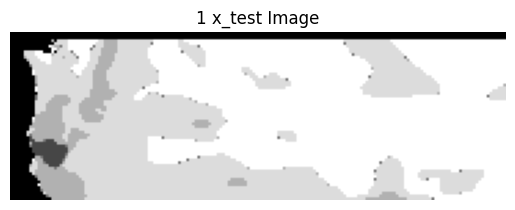

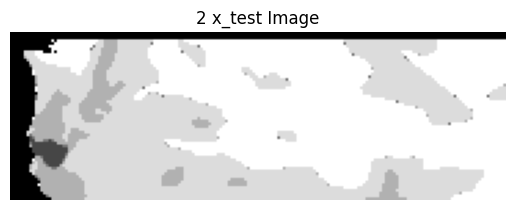

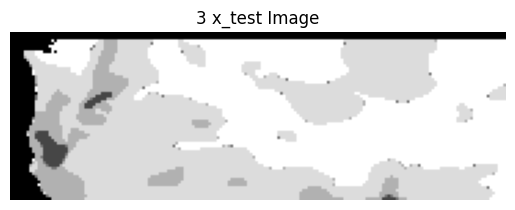

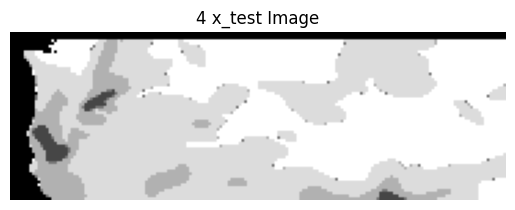

In [90]:
x_test = x_test[imagenInicial]
for i in range(horizon):
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f"{i+1} x_test Image")
    plt.axis('off')
    plt.show()